In [2]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt 
from scipy import stats

# Load Data (ZRI, ACS) 

In [3]:
zri = pd.read_csv('../data/zri_multifamily_v2.csv')
zri['zip'] = zri['zip'].astype('string')
zri['zip'] = ["0"+z if len(z)<5 else z for z in zri['zip']]
zri['year'] = pd.to_datetime(zri['year-month'],format="%Y-%m").dt.year
zri['year'] = zri['year'].astype('string')
zri['year-month'] = pd.to_datetime(zri['year-month'],format="%Y-%m")
zri = zri.drop(index=zri[zri['zip']=="11249"].index)

In [4]:
acs = pd.read_csv('../data/acs_engineered_features.csv')
acs['zip'] = acs['zip'].astype('string')
acs['zip'] = ["0"+z if len(z)<5 else z for z in acs['zip']]
acs['year_usable'] = acs['year_usable'].astype('string')

#  ZRI Data - target variable - zscore(zri), log(zri) 

<AxesSubplot:>

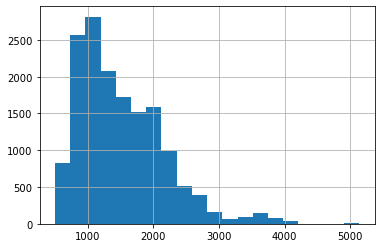

In [5]:
zri[zri['year']=='2015']['zri'].hist(bins=20)

<AxesSubplot:>

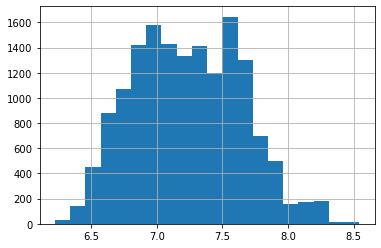

In [6]:
np.log(zri[zri['year']=='2015']['zri']).hist(bins=20)

In [7]:
zri[zri['year']=='2015']

,zip,City,State,Metro,CountyName,year-month,zri,year
12,01013,Chicopee,MA,Springfield,Hampden County,2015-01-01,946.0,2015
13,01013,Chicopee,MA,Springfield,Hampden County,2015-02-01,950.0,2015
14,01013,Chicopee,MA,Springfield,Hampden County,2015-03-01,958.0,2015
15,01013,Chicopee,MA,Springfield,Hampden County,2015-04-01,958.0,2015
16,01013,Chicopee,MA,Springfield,Hampden County,2015-05-01,955.0,2015
...,...,...,...,...,...,...,...,...
93691,99654,Wasilla,AK,Anchorage,Matanuska Susitna Borough,2015-08-01,1199.0,2015
93692,99654,Wasilla,AK,Anchorage,Matanuska Susitna Borough,2015-09-01,1188.0,2015
93693,99654,Wasilla,AK,Anchorage,Matanuska Susitna Borough,2015-10-01,1194.0,2015
93694,99654,Wasilla,AK,Anchorage,Matanuska Susitna Borough,2015-11-01,1209.0,2015


<AxesSubplot:>

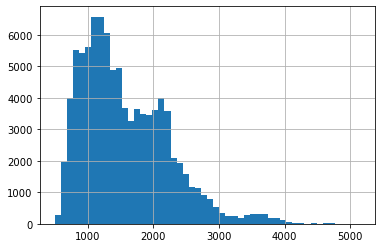

In [8]:
zri['zri'].hist(bins=50)

<AxesSubplot:>

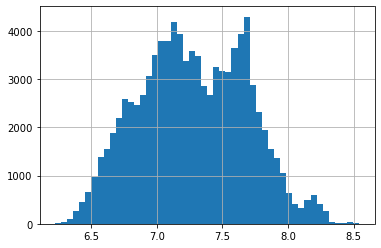

In [9]:
np.log(zri['zri']).hist(bins=50)

In [10]:
pd.Series(stats.zscore(zri[zri['zip']=='07302']['zri']))

0    -1.985107
1    -1.985107
2    -2.074549
3    -2.098942
4    -2.025762
        ...   
67    1.454330
68    1.576296
69    1.625082
70    1.673868
71    1.673868
Length: 72, dtype: float64

In [11]:
zri[zri['zip']=='07302']['zri']

14256    2135.0
14257    2135.0
14258    2124.0
14259    2121.0
14260    2130.0
          ...  
14323    2558.0
14324    2573.0
14325    2579.0
14326    2585.0
14327    2585.0
Name: zri, Length: 72, dtype: float64

In [12]:
zri['zri_zscore'] = zri['zri']

In [13]:
for z in zri['zip'].unique():
    zri.loc[zri['zip']==z,'zri_zscore'] = stats.zscore(zri.loc[zri['zip']==z,'zri'])

<AxesSubplot:>

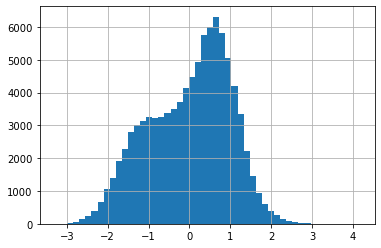

In [14]:
zri['zri_zscore'].hist(bins=50)

<AxesSubplot:>

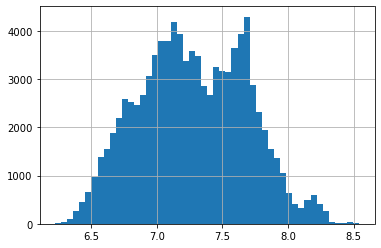

In [15]:
np.log(zri['zri']).hist(bins=50)

In [16]:
zillow = zri[['zip','City','State','year-month','year','zri']]

In [17]:
zillow

,zip,City,State,year-month,year,zri
0,01013,Chicopee,MA,2014-01-01,2014,928.0
1,01013,Chicopee,MA,2014-02-01,2014,931.0
2,01013,Chicopee,MA,2014-03-01,2014,934.0
3,01013,Chicopee,MA,2014-04-01,2014,929.0
4,01013,Chicopee,MA,2014-05-01,2014,929.0
...,...,...,...,...,...,...
93739,99654,Wasilla,AK,2019-08-01,2019,1277.0
93740,99654,Wasilla,AK,2019-09-01,2019,1271.0
93741,99654,Wasilla,AK,2019-10-01,2019,1299.0
93742,99654,Wasilla,AK,2019-11-01,2019,1261.5


# Add lagged columns
- ZRI lags: last 3 months
- ACS lags: 12 months before, 24 months before 

In [18]:
# zillow_lags = pd.DataFrame()
# for z in zillow['zip'].unique():
#     data_temp = zillow[zillow['zip']==z]
#     data_temp.loc[:,'zri_lag_1']= data_temp.loc[:,'zri'].shift(+1)
#     data_temp.loc[:,'zri_lag_2']= data_temp.loc[:,'zri'].shift(+2)
#     data_temp.loc[:,'zri_lag_3']= data_temp.loc[:,'zri'].shift(+3)
#     zillow_lags = zillow_lags.append(data_temp)
# zillow_lags[zillow_lags.isna().any(axis=1)]

In [19]:
def laggenerator(i,colname,df):
    timelist=list(df['year-month'].drop_duplicates().sort_values())[0:i]
    
    df.loc[:,f'{colname}_lag{i}']=df.loc[:,f'{colname}'].shift(i)
    
    df.loc[df['year-month'].isin(timelist),f'{colname}_lag{i}']=0
    return df

In [20]:
zillow_lags = zillow.copy()
for i in range(1,4):
    zillow_lags=laggenerator(i, 'zri',zillow_lags)

In [21]:
zillow_lags

,zip,City,State,year-month,year,zri,zri_lag1,zri_lag2,zri_lag3
0,01013,Chicopee,MA,2014-01-01,2014,928.0,0.0,0.0,0.0
1,01013,Chicopee,MA,2014-02-01,2014,931.0,928.0,0.0,0.0
2,01013,Chicopee,MA,2014-03-01,2014,934.0,931.0,928.0,0.0
3,01013,Chicopee,MA,2014-04-01,2014,929.0,934.0,931.0,928.0
4,01013,Chicopee,MA,2014-05-01,2014,929.0,929.0,934.0,931.0
...,...,...,...,...,...,...,...,...,...
93739,99654,Wasilla,AK,2019-08-01,2019,1277.0,1291.0,1294.0,1296.0
93740,99654,Wasilla,AK,2019-09-01,2019,1271.0,1277.0,1291.0,1294.0
93741,99654,Wasilla,AK,2019-10-01,2019,1299.0,1271.0,1277.0,1291.0
93742,99654,Wasilla,AK,2019-11-01,2019,1261.5,1299.0,1271.0,1277.0


In [22]:
acs

,zip,census_period,year_usable,percent_white,percent_black,percent_asian,percent_hispanic,percent_native_am,percent_other_race,percent_0_17,...,median_building_age,income_per_capita,poverty_rate,total_pop,percent_workforce_unemployed,percent_work_from_home,median_age,percent_female,gini_index,percent_not_us_citizen
0,01013,20072011,2013,0.729579,0.020723,0.013756,0.218793,0.000000,0.005002,0.230494,...,62.0,20433.0,0.190522,22391,0.104113,0.008853,36.4,0.510250,0.4210,0.055960
1,01013,20082012,2014,0.714417,0.023463,0.013473,0.231235,0.000000,0.004491,0.224682,...,62.0,20940.0,0.201543,21822,0.104320,0.014770,36.6,0.501650,0.4179,0.057190
2,01013,20092013,2015,0.720119,0.027857,0.016777,0.217971,0.001357,0.005065,0.217248,...,66.0,20889.0,0.173591,22113,0.113411,0.012946,35.5,0.506851,0.4110,0.056483
3,01013,20102014,2016,0.713799,0.017445,0.016638,0.237499,0.000538,0.002197,0.221131,...,72.0,21371.0,0.155696,22299,0.115569,0.013701,35.8,0.512669,0.4061,0.050182
4,01013,20112015,2017,0.703894,0.022238,0.018442,0.241627,0.001116,0.001652,0.222336,...,73.0,21477.0,0.169816,22394,0.114075,0.020243,34.9,0.514200,0.4117,0.050013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92647,99901,20092013,2015,0.653872,0.002271,0.063146,0.044026,0.142407,0.002710,0.233756,...,38.0,31563.0,0.101846,13651,0.086316,0.021073,38.7,0.478353,0.3981,0.025493
92648,99901,20102014,2016,0.654374,0.004016,0.061487,0.046444,0.143932,0.000000,0.232584,...,38.0,31487.0,0.114447,13694,0.085095,0.022509,38.8,0.481233,0.4057,0.023952
92649,99901,20112015,2017,0.649705,0.004228,0.073631,0.048334,0.135379,0.001604,0.230079,...,40.0,32010.0,0.121194,13717,0.078951,0.023050,38.7,0.485602,0.4110,0.025953
92650,99901,20122016,2018,0.645762,0.004947,0.076319,0.046126,0.129138,0.005384,0.225609,...,40.0,32671.0,0.108124,13745,0.075428,0.026582,39.2,0.485922,0.4158,0.035504


In [23]:
merged = pd.merge(zillow_lags,acs,how='left',left_on=["zip","year"],right_on=["zip","year_usable"])
#merged.head(36)[['zip','City','year-month','year','percent_white']]

In [24]:
acs_lags = merged.copy()

In [25]:
acs_cols = ['percent_white',
       'percent_black', 'percent_asian', 'percent_hispanic',
       'percent_native_am', 'percent_other_race', 'percent_0_17',
       'percent_18_39', 'percent_40_64', 'percent_65+',
       'percent_rental_units_vacant', 'percent_rental_units_occupied',
       'percent_graduate_deg', 'percent_bachelors', 'percent_associates',
       'percent_highschool', 'percent_less_highschool',
       'percent_commute_public_transport', 'percent_commute_less_30',
       'percent_commute_30_to_59', 'percent_commute_60_to_89',
       'percent_commute_90_more', 'percent_new_city', 'percent_new_unit',
       'percent_units_owner_occupied', 'median_building_age',
       'income_per_capita', 'poverty_rate', 'total_pop',
       'percent_workforce_unemployed', 'percent_work_from_home', 'median_age',
       'percent_female', 'gini_index', 'percent_not_us_citizen']


for col in acs_cols:
    for i in [12,24]:
        acs_lags=laggenerator(i,col,acs_lags)

In [26]:
acs_lags.tail()

,zip,City,State,year-month,year,zri,zri_lag1,zri_lag2,zri_lag3,census_period,...,percent_work_from_home_lag12,percent_work_from_home_lag24,median_age_lag12,median_age_lag24,percent_female_lag12,percent_female_lag24,gini_index_lag12,gini_index_lag24,percent_not_us_citizen_lag12,percent_not_us_citizen_lag24
93667,99654,Wasilla,AK,2019-08-01,2019,1277.0,1291.0,1294.0,1296.0,20132017,...,0.047433,0.042248,33.5,33.2,0.47311,0.474887,0.3974,0.3889,0.016234,0.022725
93668,99654,Wasilla,AK,2019-09-01,2019,1271.0,1277.0,1291.0,1294.0,20132017,...,0.047433,0.042248,33.5,33.2,0.47311,0.474887,0.3974,0.3889,0.016234,0.022725
93669,99654,Wasilla,AK,2019-10-01,2019,1299.0,1271.0,1277.0,1291.0,20132017,...,0.047433,0.042248,33.5,33.2,0.47311,0.474887,0.3974,0.3889,0.016234,0.022725
93670,99654,Wasilla,AK,2019-11-01,2019,1261.5,1299.0,1271.0,1277.0,20132017,...,0.047433,0.042248,33.5,33.2,0.47311,0.474887,0.3974,0.3889,0.016234,0.022725
93671,99654,Wasilla,AK,2019-12-01,2019,1224.0,1261.5,1299.0,1271.0,20132017,...,0.047433,0.042248,33.5,33.2,0.47311,0.474887,0.3974,0.3889,0.016234,0.022725


In [27]:
temp = acs_lags[acs_lags['year']=='2015']

In [28]:
from sklearn.preprocessing import StandardScaler

In [29]:
scaler = StandardScaler()
temp_num_scaled = scaler.fit_transform(temp.select_dtypes(['int','float']))

In [30]:
temp.select_dtypes(['int','float']).columns.to_list()

['zri',
 'zri_lag1',
 'zri_lag2',
 'zri_lag3',
 'census_period',
 'percent_white',
 'percent_black',
 'percent_asian',
 'percent_hispanic',
 'percent_native_am',
 'percent_other_race',
 'percent_0_17',
 'percent_18_39',
 'percent_40_64',
 'percent_65+',
 'percent_rental_units_vacant',
 'percent_rental_units_occupied',
 'percent_graduate_deg',
 'percent_bachelors',
 'percent_associates',
 'percent_highschool',
 'percent_less_highschool',
 'percent_commute_public_transport',
 'percent_commute_less_30',
 'percent_buildings_less_10_units',
 'percent_buildings_10_19_units',
 'percent_buildings_20_49_units',
 'percent_buildings_50+_units',
 'percent_commute_30_to_59',
 'percent_commute_60_to_89',
 'percent_commute_90_more',
 'percent_new_city',
 'percent_new_unit',
 'percent_units_owner_occupied',
 'median_building_age',
 'income_per_capita',
 'poverty_rate',
 'total_pop',
 'percent_workforce_unemployed',
 'percent_work_from_home',
 'median_age',
 'percent_female',
 'gini_index',
 'percent_n

In [31]:
temp.loc[:,temp.select_dtypes(['int','float']).columns]= temp_num_scaled

/Users/nikiagrawal/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [68]:
temp

,zip,City,State,year-month,year,zri,zri_lag1,zri_lag2,zri_lag3,census_period,...,percent_work_from_home_lag12,percent_work_from_home_lag24,median_age_lag12,median_age_lag24,percent_female_lag12,percent_female_lag24,gini_index_lag12,gini_index_lag24,percent_not_us_citizen_lag12,percent_not_us_citizen_lag24
12,01013,Chicopee,MA,2015-01-01,2015,-0.863797,-0.859367,-0.852120,-0.846621,0.0,...,-1.052984,0.0,0.253294,0.0,-0.356011,0.0,-0.708995,0.0,-0.721029,0.0
13,01013,Chicopee,MA,2015-02-01,2015,-0.857689,-0.857830,-0.853668,-0.846621,0.0,...,-1.052984,0.0,0.253294,0.0,-0.356011,0.0,-0.708995,0.0,-0.721029,0.0
14,01013,Chicopee,MA,2015-03-01,2015,-0.845472,-0.851683,-0.852120,-0.848182,0.0,...,-1.052984,0.0,0.253294,0.0,-0.356011,0.0,-0.708995,0.0,-0.721029,0.0
15,01013,Chicopee,MA,2015-04-01,2015,-0.845472,-0.839388,-0.845926,-0.846621,0.0,...,-1.052984,0.0,0.253294,0.0,-0.356011,0.0,-0.708995,0.0,-0.721029,0.0
16,01013,Chicopee,MA,2015-05-01,2015,-0.850053,-0.839388,-0.833539,-0.840375,0.0,...,-1.052984,0.0,0.253294,0.0,-0.356011,0.0,-0.708995,0.0,-0.721029,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93619,99654,Wasilla,AK,2015-08-01,2015,-0.477453,-0.435182,-0.409289,-0.376631,0.0,...,0.219808,0.0,-0.480814,0.0,-1.068810,0.0,-1.294275,0.0,-1.168040,0.0
93620,99654,Wasilla,AK,2015-09-01,2015,-0.494250,-0.468994,-0.426321,-0.400052,0.0,...,0.219808,0.0,-0.480814,0.0,-1.068810,0.0,-1.294275,0.0,-1.168040,0.0
93621,99654,Wasilla,AK,2015-10-01,2015,-0.485088,-0.485900,-0.460385,-0.417228,0.0,...,0.219808,0.0,-0.480814,0.0,-1.068810,0.0,-1.294275,0.0,-1.168040,0.0
93622,99654,Wasilla,AK,2015-11-01,2015,-0.462182,-0.476678,-0.477417,-0.451579,0.0,...,0.219808,0.0,-0.480814,0.0,-1.068810,0.0,-1.294275,0.0,-1.168040,0.0


<AxesSubplot:>

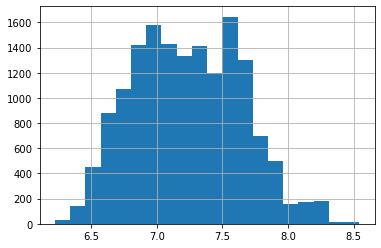

In [36]:
np.log(acs_lags[acs_lags['year']=='2015']['zri']).hist(bins=20)

<AxesSubplot:>

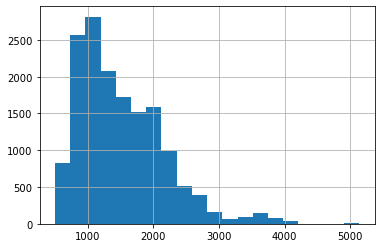

In [33]:
acs_lags[acs_lags['year']=='2015']['zri'].hist(bins=20)

<AxesSubplot:>

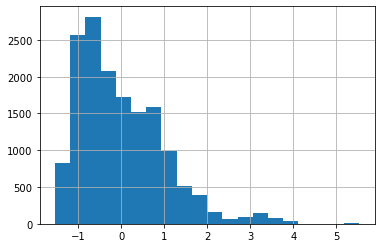

In [34]:
temp['zri'].hist(bins=20)

/Users/nikiagrawal/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:>

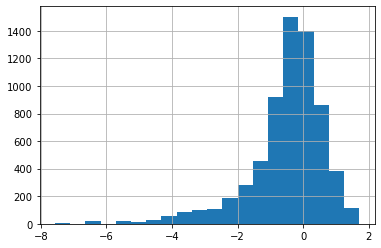

In [35]:
np.log(temp['zri']).hist(bins=20)

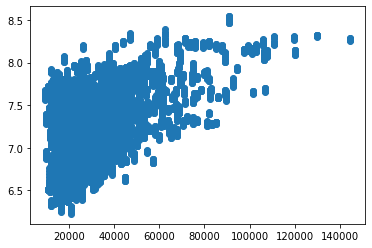

In [40]:
plt.scatter(x=temp['income_per_capita'],y=np.log(temp['zri']))

# Split train and test

In [298]:
acs_lags['year'] = acs_lags['year'].astype(int)

In [299]:
train = acs_lags[acs_lags['year'] < 2019]
test = acs_lags[acs_lags['year']==2019]

In [300]:
train_y = train['zri']
train_X = train.drop(['zri','year-month','year','census_period','year_usable'],axis=1)

test_y = test['zri']
test_X = test.drop(['zri','year-month','year','census_period','year_usable'],axis=1)

In [301]:
train_X

,zip,City,State,zri_lag1,zri_lag2,zri_lag3,percent_white,percent_black,percent_asian,percent_hispanic,...,percent_work_from_home_lag12,percent_work_from_home_lag24,median_age_lag12,median_age_lag24,percent_female_lag12,percent_female_lag24,gini_index_lag12,gini_index_lag24,percent_not_us_citizen_lag12,percent_not_us_citizen_lag24
0,01013,Chicopee,MA,0.0,0.0,0.0,0.714417,0.023463,0.013473,0.231235,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000
1,01013,Chicopee,MA,928.0,0.0,0.0,0.714417,0.023463,0.013473,0.231235,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000
2,01013,Chicopee,MA,931.0,928.0,0.0,0.714417,0.023463,0.013473,0.231235,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000
3,01013,Chicopee,MA,934.0,931.0,928.0,0.714417,0.023463,0.013473,0.231235,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000
4,01013,Chicopee,MA,929.0,934.0,931.0,0.714417,0.023463,0.013473,0.231235,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93655,99654,Wasilla,AK,1332.0,1334.0,1335.0,0.798655,0.009730,0.015504,0.048770,...,0.042248,0.039896,33.2,33.2,0.474887,0.476292,0.3889,0.3925,0.022725,0.020933
93656,99654,Wasilla,AK,1337.0,1332.0,1334.0,0.798655,0.009730,0.015504,0.048770,...,0.042248,0.039896,33.2,33.2,0.474887,0.476292,0.3889,0.3925,0.022725,0.020933
93657,99654,Wasilla,AK,1337.0,1337.0,1332.0,0.798655,0.009730,0.015504,0.048770,...,0.042248,0.039896,33.2,33.2,0.474887,0.476292,0.3889,0.3925,0.022725,0.020933
93658,99654,Wasilla,AK,1335.0,1337.0,1337.0,0.798655,0.009730,0.015504,0.048770,...,0.042248,0.039896,33.2,33.2,0.474887,0.476292,0.3889,0.3925,0.022725,0.020933


In [424]:
train.iloc[0:,0:46].corr()

,year,zri,zri_lag1,zri_lag2,zri_lag3,census_period,percent_white,percent_black,percent_asian,percent_hispanic,...,median_building_age,income_per_capita,poverty_rate,total_pop,percent_workforce_unemployed,percent_work_from_home,median_age,percent_female,gini_index,percent_not_us_citizen
year,1.000000,0.117023,0.163664,0.207690,0.249568,1.000000,-0.022961,-0.001987,0.024136,0.013488,...,0.056600,0.046520,0.001674,0.028899,-0.165994,0.066135,0.037441,-0.009346,0.046284,-0.019481
zri,0.117023,1.000000,0.958793,0.922490,0.890311,0.117023,-0.099561,-0.194781,0.449726,0.110956,...,0.129708,0.537049,-0.252315,0.066662,-0.253857,0.322635,0.103757,-0.062355,0.218463,0.398085
zri_lag1,0.163664,0.958793,1.000000,0.961404,0.927003,0.163664,-0.095380,-0.184878,0.427706,0.105696,...,0.126188,0.512010,-0.238294,0.064753,-0.245299,0.309038,0.100275,-0.059144,0.210046,0.376336
zri_lag2,0.207690,0.922490,0.961404,1.000000,0.963595,0.207690,-0.091683,-0.176135,0.408303,0.101006,...,0.123183,0.490053,-0.225873,0.063135,-0.238029,0.297194,0.097319,-0.056329,0.202778,0.357005
zri_lag3,0.249568,0.890311,0.927003,0.963595,1.000000,0.249568,-0.088417,-0.168325,0.391012,0.096828,...,0.120602,0.470579,-0.214730,0.061771,-0.231794,0.286783,0.094772,-0.053860,0.196439,0.339667
census_period,1.000000,0.117023,0.163664,0.207690,0.249568,1.000000,-0.022961,-0.001987,0.024136,0.013488,...,0.056600,0.046520,0.001674,0.028899,-0.165994,0.066135,0.037441,-0.009346,0.046284,-0.019481
percent_white,-0.022961,-0.099561,-0.095380,-0.091683,-0.088417,-0.022961,1.000000,-0.580223,-0.119008,-0.644781,...,-0.206262,0.473421,-0.530205,-0.340520,-0.596096,0.395231,0.392740,-0.116965,0.010237,-0.584857
percent_black,-0.001987,-0.194781,-0.184878,-0.176135,-0.168325,-0.001987,-0.580223,1.000000,-0.252848,-0.124063,...,0.247426,-0.345572,0.465617,0.054751,0.626303,-0.295765,-0.197861,0.365198,0.126993,-0.116528
percent_asian,0.024136,0.449726,0.427706,0.408303,0.391012,0.024136,-0.119008,-0.252848,1.000000,-0.086206,...,-0.104668,0.254154,-0.223953,0.063400,-0.247686,0.127813,0.018349,-0.140418,-0.024172,0.365832
percent_hispanic,0.013488,0.110956,0.105696,0.101006,0.096828,0.013488,-0.644781,-0.124063,-0.086206,1.000000,...,0.069652,-0.378150,0.324367,0.360765,0.258637,-0.270005,-0.302823,-0.134325,-0.116020,0.694331


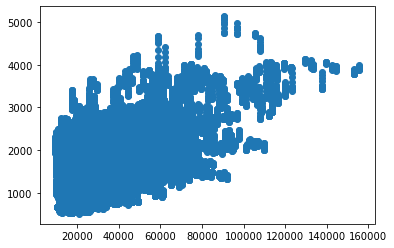

In [404]:
plt.scatter(train_X['income_per_capita'],train_y)

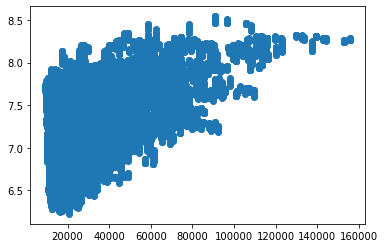

In [405]:
plt.scatter(train_X['income_per_capita'],np.log(train_y))

# LASSO

In [331]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

### Label Encode Zip, City, State

In [303]:
label_encoder_zip = LabelEncoder()
label_encoder_city = LabelEncoder()
label_encoder_state = LabelEncoder()

In [304]:
train_X['zip'] = label_encoder_zip.fit_transform(train_X['zip'])
train_X['City'] = label_encoder_city.fit_transform(train_X['City'])
train_X['State'] = label_encoder_state.fit_transform(train_X['State'])

In [305]:
test_X['zip'] = label_encoder_zip.transform(test_X['zip'])
test_X['City'] = label_encoder_city.transform(test_X['City'])
test_X['State'] = label_encoder_state.transform(test_X['State'])

In [306]:
set(train_X['zip']) == set(test_X['zip'])

True

### Standard Scaler

In [312]:
scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_X)
test_X_scaled = scaler.transform(test_X)

In [339]:
train_X

,zip,City,State,zri_lag1,zri_lag2,zri_lag3,percent_white,percent_black,percent_asian,percent_hispanic,...,percent_work_from_home_lag12,percent_work_from_home_lag24,median_age_lag12,median_age_lag24,percent_female_lag12,percent_female_lag24,gini_index_lag12,gini_index_lag24,percent_not_us_citizen_lag12,percent_not_us_citizen_lag24
0,0,84,15,0.0,0.0,0.0,0.714417,0.023463,0.013473,0.231235,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000
1,0,84,15,928.0,0.0,0.0,0.714417,0.023463,0.013473,0.231235,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000
2,0,84,15,931.0,928.0,0.0,0.714417,0.023463,0.013473,0.231235,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000
3,0,84,15,934.0,931.0,928.0,0.714417,0.023463,0.013473,0.231235,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000
4,0,84,15,929.0,934.0,931.0,0.714417,0.023463,0.013473,0.231235,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93655,1300,510,0,1332.0,1334.0,1335.0,0.798655,0.009730,0.015504,0.048770,...,0.042248,0.039896,33.2,33.2,0.474887,0.476292,0.3889,0.3925,0.022725,0.020933
93656,1300,510,0,1337.0,1332.0,1334.0,0.798655,0.009730,0.015504,0.048770,...,0.042248,0.039896,33.2,33.2,0.474887,0.476292,0.3889,0.3925,0.022725,0.020933
93657,1300,510,0,1337.0,1337.0,1332.0,0.798655,0.009730,0.015504,0.048770,...,0.042248,0.039896,33.2,33.2,0.474887,0.476292,0.3889,0.3925,0.022725,0.020933
93658,1300,510,0,1335.0,1337.0,1337.0,0.798655,0.009730,0.015504,0.048770,...,0.042248,0.039896,33.2,33.2,0.474887,0.476292,0.3889,0.3925,0.022725,0.020933


In [338]:
train_X_scaled

array([[-1.73072   , -1.18355718, -0.31120377, ..., -1.20353618,
        -1.06048559, -0.8097274 ],
       [-1.73072   , -1.18355718, -0.31120377, ..., -1.20353618,
        -1.06048559, -0.8097274 ],
       [-1.73072   , -1.18355718, -0.31120377, ..., -1.20353618,
        -1.06048559, -0.8097274 ],
       ...,
       [ 1.73072   ,  1.65706001, -1.49389929, ...,  0.50930001,
        -0.8044568 , -0.57071481],
       [ 1.73072   ,  1.65706001, -1.49389929, ...,  0.50930001,
        -0.8044568 , -0.57071481],
       [ 1.73072   ,  1.65706001, -1.49389929, ...,  0.50930001,
        -0.8044568 , -0.57071481]])

In [443]:
lasso = Lasso()
grid = dict()
grid['alpha'] = [1e-15, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2, 1, 5, 10]

grid

{'alpha': [1e-15, 1e-10, 1e-08, 1e-05, 0.0001, 0.001, 0.01, 1, 5, 10]}

In [444]:
#clf = GridSearchCV(lasso, grid, cv=5, n_jobs=-1)

In [445]:
#lasso_grid = clf.fit(train_X_scaled,train_y)

In [446]:
lasso_grid.best_params_

{'alpha': 10}

In [447]:
lasso_grid.best_score_

0.8723623164261121

In [454]:
#lasso = lasso_grid.best_estimator_
lasso = Lasso(alpha=0.95)
lasso.fit(train_X_scaled, train_y)

Lasso(alpha=0.95)

In [455]:
lasso.fit(train_X_scaled, train_y)

Lasso(alpha=0.95)

In [456]:
print('LASSO')
print(f'R2: {lasso.score(test_X_scaled,test_y)}')
print(f'RMSE: {sqrt(mean_squared_error(lasso.predict(test_X_scaled),test_y))}')

LASSO
R2: 0.9845364738047435
RMSE: 82.7329513873741


# Feature importances (Non-zero coefficients )

In [457]:
importance = np.abs(lasso.coef_)
coef = lasso.coef_
feature_names = np.array(train_X.columns.to_list())

In [458]:
importance.shape

(111,)

In [459]:
feature_importances= pd.DataFrame([feature_names,importance,coef]).T
feature_importances.columns = ['feature_names','coef_abs','coef']

In [460]:
feature_importances = feature_importances.sort_values(by='coef_abs',ascending=False)
feature_importances[feature_importances['coef_abs']>0]

,feature_names,coef_abs,coef
3,zri_lag1,469.904548,469.904548
32,income_per_capita,102.73244,102.73244
5,zri_lag3,45.947818,45.947818
23,percent_commute_public_transport,39.158153,39.158153
2,State,34.323307,-34.323307
65,percent_graduate_deg_lag12,26.886471,-26.886471
8,percent_asian,25.869581,25.869581
16,percent_rental_units_vacant,25.660053,-25.660053
29,percent_new_unit,23.669399,-23.669399
40,percent_not_us_citizen,23.295909,23.295909


In [461]:
sfm = SelectFromModel(lasso).fit(train_X_scaled, train_y)
print("Features selected by SelectFromModel: \n"
      f"{feature_names[sfm.get_support()]}")

Features selected by SelectFromModel: 
['City' 'State' 'zri_lag1' 'zri_lag3' 'percent_white' 'percent_asian'
 'percent_hispanic' 'percent_native_am' 'percent_other_race'
 'percent_0_17' 'percent_40_64' 'percent_rental_units_vacant'
 'percent_graduate_deg' 'percent_bachelors' 'percent_associates'
 'percent_highschool' 'percent_commute_public_transport'
 'percent_commute_less_30' 'percent_commute_30_to_59'
 'percent_commute_90_more' 'percent_new_city' 'percent_new_unit'
 'percent_units_owner_occupied' 'median_building_age' 'income_per_capita'
 'total_pop' 'percent_work_from_home' 'percent_female' 'gini_index'
 'percent_not_us_citizen' 'percent_other_race_lag24'
 'percent_rental_units_vacant_lag12' 'percent_rental_units_vacant_lag24'
 'percent_graduate_deg_lag12' 'percent_graduate_deg_lag24'
 'percent_bachelors_lag12' 'percent_associates_lag24'
 'percent_highschool_lag12' 'percent_commute_public_transport_lag12'
 'percent_commute_60_to_89_lag12' 'percent_commute_90_more_lag24'
 'percent_n

In [462]:
feature_names[sfm.get_support()].shape

(45,)

In [463]:
zri

,zip,City,State,Metro,CountyName,year-month,zri,year
0,01013,Chicopee,MA,Springfield,Hampden County,2014-01-01,928.0,2014
1,01013,Chicopee,MA,Springfield,Hampden County,2014-02-01,931.0,2014
2,01013,Chicopee,MA,Springfield,Hampden County,2014-03-01,934.0,2014
3,01013,Chicopee,MA,Springfield,Hampden County,2014-04-01,929.0,2014
4,01013,Chicopee,MA,Springfield,Hampden County,2014-05-01,929.0,2014
...,...,...,...,...,...,...,...,...
93739,99654,Wasilla,AK,Anchorage,Matanuska Susitna Borough,2019-08-01,1277.0,2019
93740,99654,Wasilla,AK,Anchorage,Matanuska Susitna Borough,2019-09-01,1271.0,2019
93741,99654,Wasilla,AK,Anchorage,Matanuska Susitna Borough,2019-10-01,1299.0,2019
93742,99654,Wasilla,AK,Anchorage,Matanuska Susitna Borough,2019-11-01,1261.5,2019
